Using Gee and ee (google earth engine) this file is importing SAR level 1 datas and convert it into the TIF files of regions that we are interested in. After downloading the files, one can integrate and analyze it to generate pixel datas and histograms, to calculate its FDI or RVI. 

In [14]:
# Step 1: Install and import necessary libraries
# The geemap library makes working with Google Earth Engine in Python much easier.
# !pip install geemap
import ee
import geemap

# Step 2: Authenticate and initialize the Earth Engine library.
# This will prompt you to log in with a Google account and grant permissions.

# Corrected code
# Replace 'your-project-id-goes-here' with your actual Project ID
project_id = 'geesecrossing'

try:
    ee.Initialize(project=project_id)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=project_id)

print("Authentication and initialization successful!")

Authentication and initialization successful!


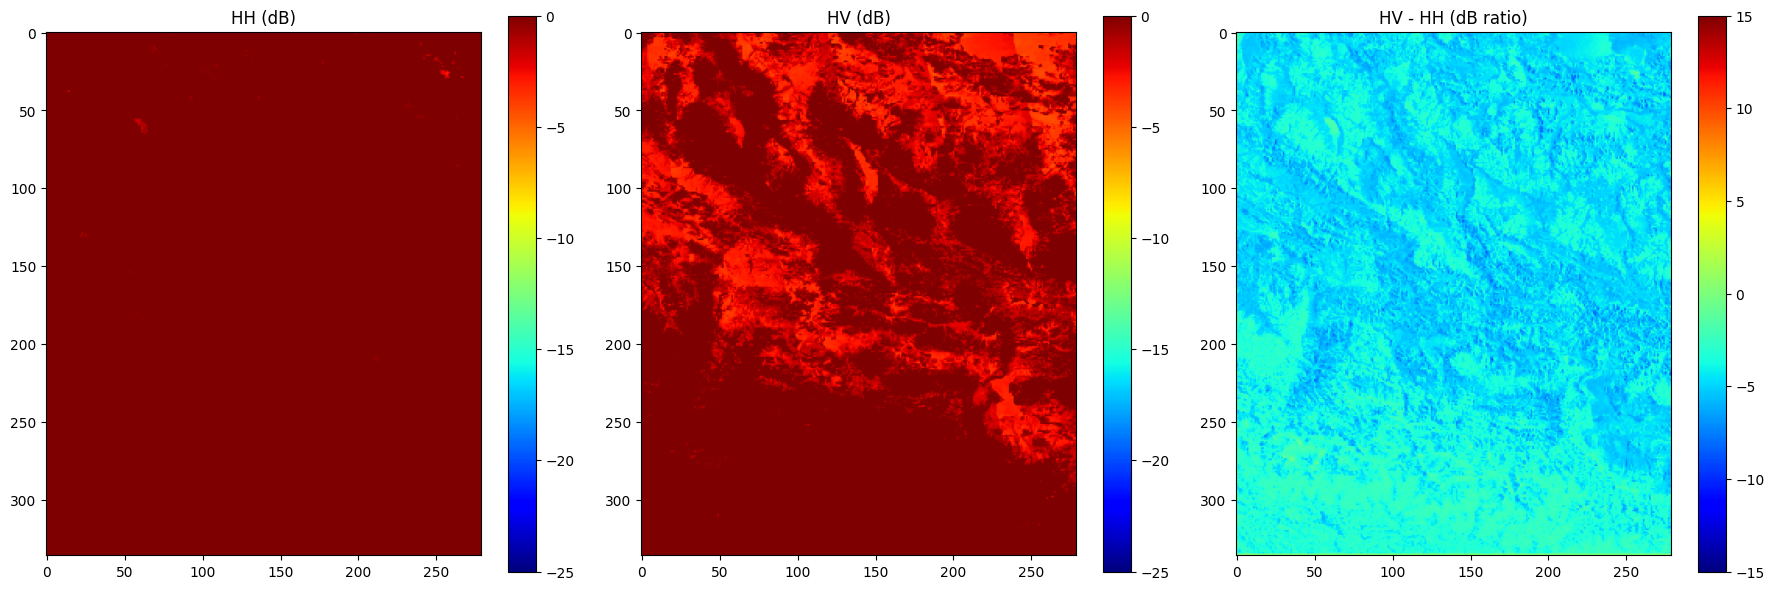

In [2]:
import geemap
import ee
import matplotlib.pyplot as plt

# GEE 초기화
ee.Initialize(project=project_id)
roi = ee.Geometry.Polygon( [[[83.5, 31], [83.5, 28.0], [86.0, 28.0], [86.0, 31]]] )
# ALOS PALSAR 2008 Mosaic
alos = ee.ImageCollection("JAXA/ALOS/PALSAR/YEARLY/SAR") \
           .filterDate("2008-01-01", "2008-12-31") \
           .mosaic().clip(roi)

# DN → dB 변환
hh_dB = alos.select('HH').multiply(0.001).log10().multiply(10)
hv_dB = alos.select('HV').multiply(0.001).log10().multiply(10)
ratio = hv_dB.subtract(hh_dB)   # HV/HH 비율을 dB 차이로 표현
resolution = 1000
# numpy array로 변환 (roi 영역에서 export)
hh_array = geemap.ee_to_numpy(hh_dB, region=roi, scale=resolution)
hv_array = geemap.ee_to_numpy(hv_dB, region=roi, scale=resolution)
ratio_array = geemap.ee_to_numpy(ratio, region=roi, scale=resolution)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im1 = axes[0].imshow(hh_array, cmap='jet', vmin=-25, vmax=0)
axes[0].set_title("HH (dB)")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(hv_array, cmap='jet', vmin=-25, vmax=0)
axes[1].set_title("HV (dB)")
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(ratio_array, cmap='jet', vmin=-15, vmax=15)
axes[2].set_title("HV - HH (dB ratio)")
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()


In [3]:
import shutil, os

out_dir = "/content/ALOS_PALSAR_2008_tiles_1deg"
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)  # 폴더 통째 삭제
os.makedirs(out_dir, exist_ok=True)
print("📂 저장 경로 초기화 완료:", out_dir)


import numpy as np

def plot_with_scaling(array, ax, title, band_type="hh", cmap="jet"):
    # NaN 제거
    if array is None or np.all(np.isnan(array)):
        ax.set_title(f"{title} (no data)")
        return None

    # 밴드 타입별 고정 스케일
    if band_type.lower() == "hh" or band_type.lower() == "hv":
        vmin, vmax = -25, 0
    elif band_type.lower() == "ratio":
        vmin, vmax = -15, 15
    else:
        vmin, vmax = np.nanmin(array), np.nanmax(array)  # fallback

    im = ax.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    return im


📂 저장 경로 초기화 완료: /content/ALOS_PALSAR_2008_tiles_1deg


In [10]:
# Sentinel-1 데이터 개수 확인
sentinel_count = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(roi_himalaya) \
    .filterDate("2018-01-01", "2018-12-31") \
    .size() \
    .getInfo()

print("Sentinel-1 이미지 수:", sentinel_count)


Sentinel-1 이미지 수: 8547


In [5]:
import ee
import geemap
import os

# GEE 초기화
ee.Initialize(project=project_id)
# 히말라야 ROI (적당히 큰 범위)
anglerange = [75, 25, 100, 40]
roi_himalaya = ee.Geometry.Rectangle(anglerange)

# =============================
# 밴드 선택
# 밴드 타입 선택: "cband" or "lband"
band_name = "cband"   # 바꿔가면서 실행

if band_name.lower() == "cband":
    # =============================
    # Sentinel-1 (C-band, VV/VH)
    # =============================
    sentinel = (
        ee.ImageCollection("COPERNICUS/S1_GRD")
          .filterBounds(roi_himalaya)
          .filterDate("2018-01-01", "2018-12-31")   # Sentinel-1은 2014년 이후 자료만 존재
          .filter(ee.Filter.eq("instrumentMode", "IW"))
          .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
          .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))
          .median()
          .clip(roi_himalaya)
    )

    vv_dB = sentinel.select("VV").log10().multiply(10).rename("VV_dB")
    vh_dB = sentinel.select("VH").log10().multiply(10).rename("VH_dB")
    ratio = vh_dB.subtract(vv_dB).rename("VH_VV_ratio")

    final_image = vv_dB.addBands(vh_dB).addBands(ratio)
    band_for_count = vv_dB  # 픽셀 카운트용 밴드

elif band_name.lower() == "lband":
    # =============================
    # ALOS PALSAR (L-band, HH/HV)
    # =============================
    alos = (
        ee.ImageCollection("JAXA/ALOS/PALSAR/YEARLY/SAR")
          .filterDate("2008-01-01", "2008-12-31")
          .first()
          .clip(roi_himalaya)
    )

    hh_dB = alos.select("HH").multiply(0.001).log10().multiply(10).rename("HH_dB")
    hv_dB = alos.select("HV").multiply(0.001).log10().multiply(10).rename("HV_dB")
    ratio = hv_dB.subtract(hh_dB).rename("HV_HH_ratio")

    final_image = hh_dB.addBands(hv_dB).addBands(ratio)
    band_for_count = hh_dB  # 픽셀 카운트용 밴드

else:
    raise ValueError("band_name 은 'cband' 또는 'lband' 로 지정해야 합니다.")

# =============================
# 저장 폴더 (밴드 이름 반영)
# =============================
out_dir = f"/content/{band_name.upper()}_tiles_1deg"
os.makedirs(out_dir, exist_ok=True)
print("📂 저장 경로:", out_dir)

# =============================
# 타일 분할 (1° x 1°)
# =============================
step = 2
roi_himalaya = ee.Geometry.Rectangle(anglerange)
lon_min, lon_max = anglerange[0], anglerange[2]
lat_min, lat_max = anglerange[1], anglerange[3]
resolution = 1000

tile_id = 0
for lon in range(lon_min, lon_max, step):
    for lat in range(lat_min, lat_max, step):
        lon0, lon1 = lon, lon + step
        lat0, lat1 = lat, lat + step
        roi_tile = ee.Geometry.Rectangle([lon0, lat0, lon1, lat1])

        try:
            # 픽셀 개수 확인
            count_dict = band_for_count.reduceRegion(
                reducer=ee.Reducer.count(),
                geometry=roi_tile,
                scale=resolution,
                maxPixels=1e13
            ).getInfo()

            num_pixels = list(count_dict.values())[0] if count_dict else 0

            if num_pixels == 0:
                print(f"⏭️ 데이터 없음: Tile {tile_id} ({lon0}, {lat0})")
                continue

            # 파일명
            fname = os.path.join(out_dir, f"{band_name}_tile_{tile_id}.tif")

            # 타일 저장
            geemap.ee_export_image(
                final_image,
                filename=fname,
                scale=resolution,
                region=roi_tile,
                crs="EPSG:4326"
            )
            print("✅ 저장:", fname, f"(픽셀수: {num_pixels})")

        except Exception as e:
            print("❌ 실패:", f"Tile {tile_id} ({lon0}, {lat0})", e)

        tile_id += 1


📂 저장 경로: /content/CBAND_tiles_1deg
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_0.tif
✅ 저장: /content/CBAND_tiles_1deg/cband_tile_0.tif (픽셀수: 7)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_1.tif
✅ 저장: /content/CBAND_tiles_1deg/cband_tile_1.tif (픽셀수: 15)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_2.tif
✅ 저장: /content/CBAND_tiles_1deg/cband_tile_2.tif (픽셀수: 6)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_3.tif
✅ 저장: /content/CBAND_tiles_1deg/cband_tile_3.tif (픽셀수: 546)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_4.tif
✅ 저장: /content/CBAND_tiles_1deg/cband_tile_4.tif (픽셀수: 3272)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_5.tif
✅ 저장: /content/CBAND_tiles_1deg/cband_tile_5.tif (픽셀수: 7194)
Generating URL ...
Please 

In [7]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 81.9 MB/s eta 0:00:00


✅ 병합 완료: /content/CBAND_mosaic_1km.tif


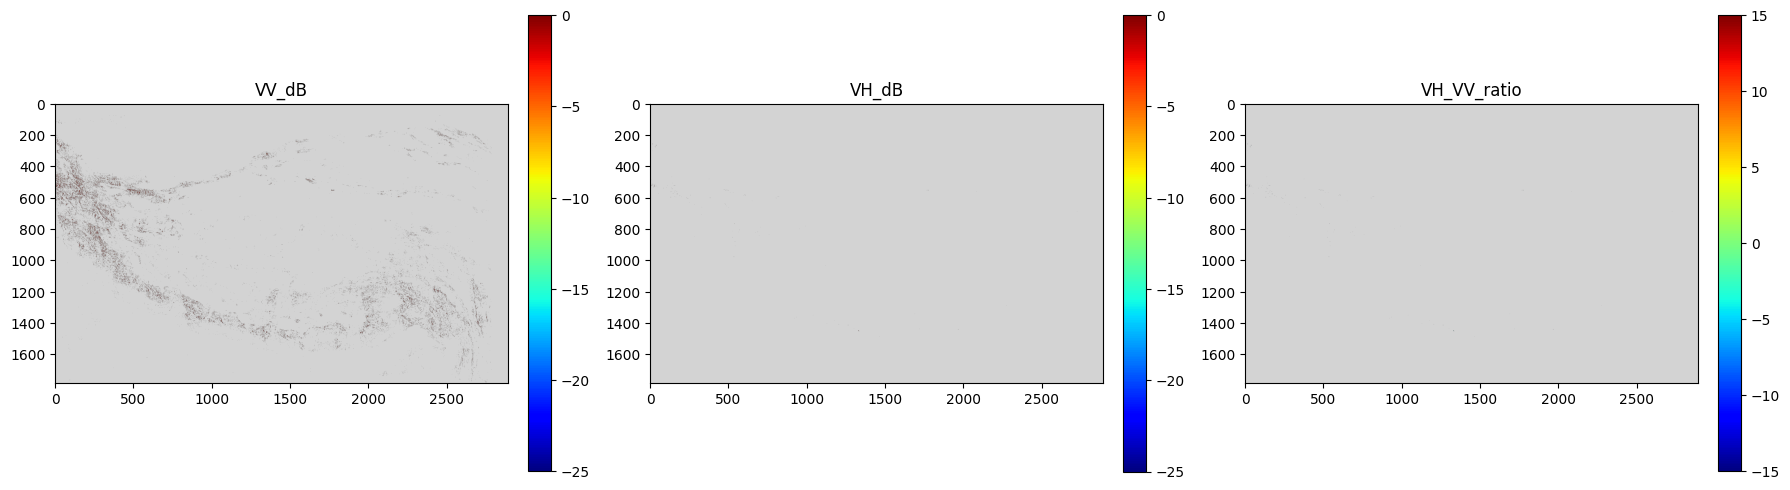

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
import glob
import os

# ============================
# 시각화 함수
# ============================
def plot_with_scaling(array, ax, title, band_type="hh", cmap="jet"):
    # NaN 제거
    if array is None or np.all(np.isnan(array)):
        ax.set_title(f"{title} (no data)")
        return None

    # 밴드 타입별 고정 스케일
    if band_type.lower() in ["hh", "hv", "vv", "vh"]:
        vmin, vmax = -25, 0
    elif band_type.lower() == "ratio":
        vmin, vmax = -15, 15
    else:
        vmin, vmax = np.nanmin(array), np.nanmax(array)  # fallback

    im = ax.imshow(band, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_facecolor("lightgray")  # NaN 영역 회색으로

    ax.set_title(title)
    return im


# ============================
# 1. 폴더 내 타일 병합
# ============================
band_name = "cband"   # "cband" or "lband"
in_dir = f"/content/{band_name.upper()}_tiles_1deg"
out_mosaic = f"/content/{band_name.upper()}_mosaic_1km.tif"

tif_files = glob.glob(os.path.join(in_dir, "*.tif"))
src_files = [rasterio.open(f) for f in tif_files]

# 병합 수행
mosaic, out_trans = merge(src_files)

# 메타데이터 갱신
out_meta = src_files[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "count": mosaic.shape[0]
})

# GeoTIFF 저장
with rasterio.open(out_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"✅ 병합 완료: {out_mosaic}")
for src in src_files:
    src.close()

# ============================
# 2. 시각화
# ============================
if band_name.lower() == "lband":
    band_titles = [("HH_dB", "hh"), ("HV_dB", "hv"), ("HV_HH_ratio", "ratio")]
else:
    band_titles = [("VV_dB", "vv"), ("VH_dB", "vh"), ("VH_VV_ratio", "ratio")]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (title, btype) in enumerate(band_titles):
    band = mosaic[i, :, :].astype(float)
    band[band == 0] = np.nan  # mask 빈값
    im = plot_with_scaling(band, axes[i], title, band_type=btype)
    if im:
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


여기부터!

In [41]:
import os
import re
import math
import ee
import geemap
from shapely.geometry import box

# =========================
# 0) EE 초기화
# =========================
try:
    ee.Initialize(project = project_id)
except Exception:
    ee.Authenticate(project = project_id)
    ee.Initialize(project = project_id)

# =========================
# 1) 대표 산맥 10개 ROI (WGS84)
#    (사용자가 제공한 그대로)
# =========================
rois = {
    "Andes":                   box(-81, -55, -60,  12),
    "Rocky Mountains":         box(-122, 31, -102, 60),
    "Alps":                    box(   5,  44,   16,  48),
    "Himalaya":                box(  72,  26,   98,  36),
    "Tien Shan":               box(  66,  39,   96,  46),
    "Atlas":                   box( -13,  27,   10,  37),
    "Great Dividing Range":    box( 146, -43,  154, -16),
    "Japanese Alps":           box( 136,  35,  139,  37.5),
    "Drakensberg":             box(  27, -31,   31, -27),
    "Taebaek (Korea)":         box( 127,  35,  130,  39),
}

# 2) 고정 인덱스 (파일명 규칙에 사용)
roi_id_map = {
    "Andes": 1,
    "Rocky Mountains": 2,
    "Alps": 3,
    "Himalaya": 4,
    "Tien Shan": 5,
    "Atlas": 6,
    "Great Dividing Range": 7,
    "Japanese Alps": 8,
    "Drakensberg": 9,
    "Taebaek (Korea)": 10,
}


In [64]:
import ee, geemap, os
from shapely.geometry import box



# -----------------------------
# 함수: shapely box → EE Rect
# -----------------------------
def box_to_ee_rect(b):
    minx, miny, maxx, maxy = b.bounds
    return ee.Geometry.Rectangle([minx, miny, maxx, maxy], proj="EPSG:4326", geodesic=False)

# -----------------------------
# SAR 데이터 생성 함수 (Sentinel-1 C-band)
# -----------------------------
def get_s1_cband(roi, start="2018-01-01", end="2018-12-31"):
    s1 = (ee.ImageCollection("COPERNICUS/S1_GRD")
          .filterBounds(roi)
          .filterDate(start, end)
          .filter(ee.Filter.eq("instrumentMode", "IW"))
          .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
          .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))
          .median()
          .clip(roi))
    vv_dB = s1.select("VV")    # 이미 dB
    vh_dB = s1.select("VH")
    ratio = vh_dB.subtract(vv_dB).rename("VH_VV_ratio")
    return vv_dB.addBands(vh_dB).addBands(ratio), vv_dB  # (최종 이미지, 카운트 밴드)


def get_palsar2_mosaic(roi, year=2017):
    dataset_id = f"JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/{year}"
    palsar = ee.Image(dataset_id).clip(roi)

    hh_dB = palsar.select("HH")
    hv_dB = palsar.select("HV")
    ratio = hv_dB.subtract(hh_dB).rename("HV_HH_ratio")

    # ⚠️ 절대 .getInfo() 사용하지 말 것
    return hh_dB.addBands(hv_dB).addBands(ratio), hh_dB


In [47]:
print(rois.items())

dict_items([('Andes', <POLYGON ((-60 -55, -60 12, -81 12, -81 -55, -60 -55))>), ('Rocky Mountains', <POLYGON ((-102 31, -102 60, -122 60, -122 31, -102 31))>), ('Alps', <POLYGON ((16 44, 16 48, 5 48, 5 44, 16 44))>), ('Himalaya', <POLYGON ((98 26, 98 36, 72 36, 72 26, 98 26))>), ('Tien Shan', <POLYGON ((96 39, 96 46, 66 46, 66 39, 96 39))>), ('Atlas', <POLYGON ((10 27, 10 37, -13 37, -13 27, 10 27))>), ('Great Dividing Range', <POLYGON ((154 -43, 154 -16, 146 -16, 146 -43, 154 -43))>), ('Japanese Alps', <POLYGON ((139 35, 139 37.5, 136 37.5, 136 35, 139 35))>), ('Drakensberg', <POLYGON ((31 -31, 31 -27, 27 -27, 27 -31, 31 -31))>), ('Taebaek (Korea)', <POLYGON ((130 35, 130 39, 127 39, 127 35, 130 35))>)])


In [65]:
# -----------------------------
# 메인 루프
# -----------------------------
base_out = r"C:\Users\kom\Downloads\ROI_Tiles_palsar"
os.makedirs(base_out, exist_ok=True)

step = 2          # 타일 크기: 2° x 2°
resolution = 1000 # 출력 해상도 (1km)

#for roi_name, shp_box in rois.items():
from shapely.geometry import Polygon

# 예시 폴리곤
#shp_box = Polygon([(98, 26), (98, 36), (72, 36), (72, 26), (98, 26)])

for roi_name, shp_box in rois.items():
    print(f"\n=== ROI: {roi_name} ===")
    print("Polygon bounds:", shp_box.bounds)
    roi = box_to_ee_rect(shp_box)

    # ROI별 저장 폴더
    out_dir = os.path.join(base_out, roi_name)
    os.makedirs(out_dir, exist_ok=True)

    # Sentinel-1 데이터 준비
    final_image, band_for_count = get_palsar2_mosaic(roi, year=2009)

    lon_min, lat_min, lon_max, lat_max = shp_box.bounds
    tile_id = 0

    for lon in range(int(lon_min), int(lon_max), step):
        for lat in range(int(lat_min), int(lat_max), step):
            lon0, lon1 = lon, lon + step
            lat0, lat1 = lat, lat + step
            roi_tile = ee.Geometry.Rectangle([lon0, lat0, lon1, lat1])

            try:
                # 픽셀 카운트
                count_dict = band_for_count.reduceRegion(
                    reducer=ee.Reducer.count(),
                    geometry=roi_tile,
                    scale=resolution,
                    maxPixels=1e13
                ).getInfo()

                num_pixels = list(count_dict.values())[0] if count_dict else 0
                if num_pixels == 0:
                    print(f"⏭️ 데이터 없음: {roi_name} Tile {tile_id} ({lon0}, {lat0})")
                    continue

                # 파일명
                fname = os.path.join(out_dir, f"{roi_name}_tile_{tile_id}.tif")

                # 저장
                geemap.ee_export_image(
                    final_image,
                    filename=fname,
                    scale=resolution,
                    region=roi_tile,
                    crs="EPSG:4326"
                )
                print(f"✅ 저장: {fname} (픽셀수: {num_pixels})")

            except Exception as e:
                print(f"❌ 실패: {roi_name} Tile {tile_id} ({lon0}, {lat0})", e)

            tile_id += 1



=== ROI: Andes ===
Polygon bounds: (-81.0, -55.0, -60.0, 12.0)
❌ 실패: Andes Tile 0 (-81, -55) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
❌ 실패: Andes Tile 1 (-81, -53) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
❌ 실패: Andes Tile 2 (-81, -51) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
❌ 실패: Andes Tile 3 (-81, -49) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
❌ 실패: Andes Tile 4 (-81, -47) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
❌ 실패: Andes Tile 5 (-81, -45) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does 

찾은 파일 수: 4
예시: ['/content/C:\\Users\\kom\\Downloads\\ROI_Tiles/Taebaek (Korea)/Taebaek (Korea)_tile_2.tif', '/content/C:\\Users\\kom\\Downloads\\ROI_Tiles/Taebaek (Korea)/Taebaek (Korea)_tile_1.tif', '/content/C:\\Users\\kom\\Downloads\\ROI_Tiles/Taebaek (Korea)/Taebaek (Korea)_tile_0.tif']
✅ 병합 완료: /content/C:\Users\kom\Downloads\ROI_TilesTaebaek (Korea)_mosaic.tif
📉 다운샘플 완료: (3, 446, 446)


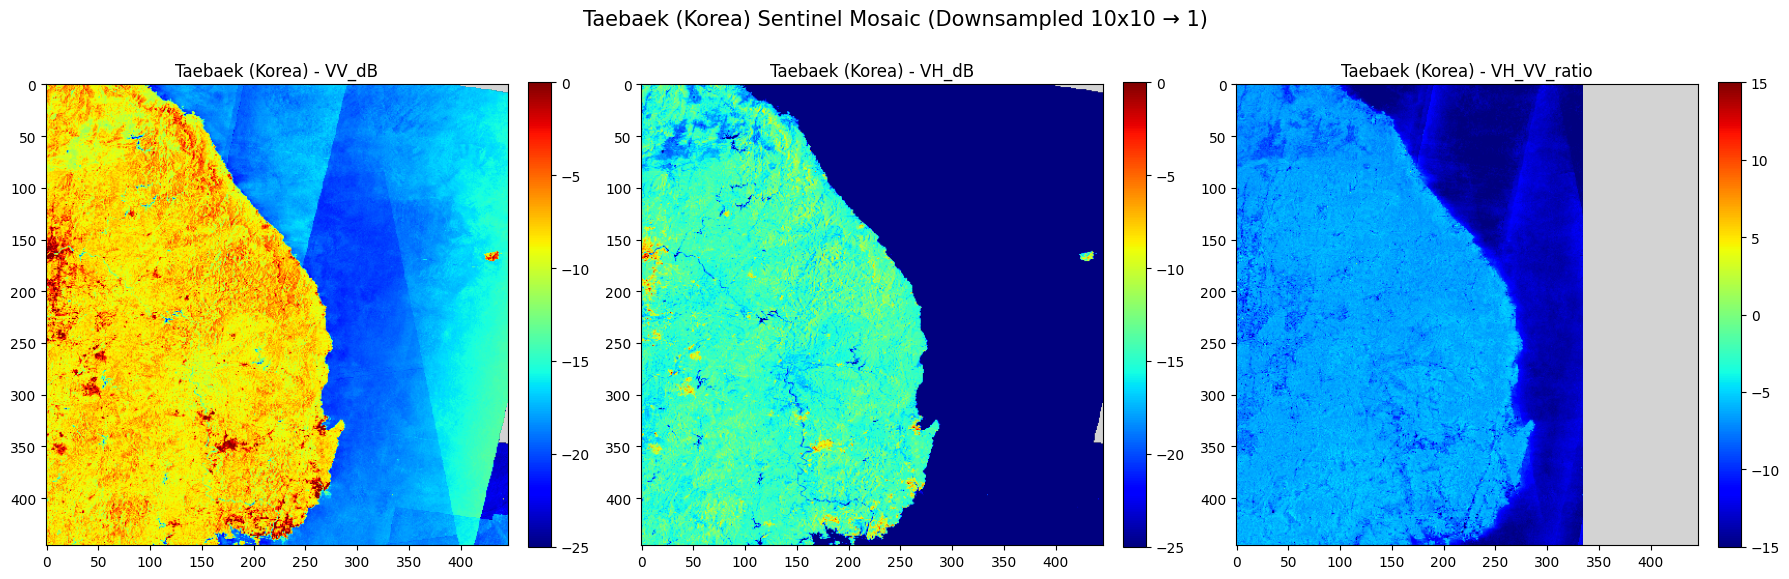

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.enums import Resampling
import glob
import os

# ============================================
# 0. 설정
# ============================================
region = "Taebaek (Korea)"

in_dir = rf"/content/C:\Users\kom\Downloads\ROI_Tiles/{region}"  # ✅ 이게 올바른 경로
out_mosaic = rf"/content/C:\Users\kom\Downloads\ROI_Tiles{region}_mosaic.tif"

import glob, os
tif_files = glob.glob(os.path.join(in_dir, "*.tif"))
print("찾은 파일 수:", len(tif_files))
print("예시:", tif_files[:3])


src_files = [rasterio.open(f) for f in tif_files]
mosaic, out_trans = merge(src_files)

# 메타데이터 갱신
out_meta = src_files[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "count": mosaic.shape[0]
})

# 병합 파일 저장
with rasterio.open(out_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"✅ 병합 완료: {out_mosaic}")

for src in src_files:
    src.close()

# ============================================
# 2. 해상도 축소 (10x10 픽셀 → 1픽셀로 축소)
# ============================================
scale_factor = 1  # 10x10 축소

new_height = mosaic.shape[1] // scale_factor
new_width = mosaic.shape[2] // scale_factor

mosaic_downscaled = np.zeros((mosaic.shape[0], new_height, new_width), dtype=np.float32)

with rasterio.open(out_mosaic) as dataset:
    for i in range(dataset.count):
        mosaic_downscaled[i] = dataset.read(
            i + 1,
            out_shape=(new_height, new_width),
            resampling=Resampling.average
        )

print(f"📉 다운샘플 완료: {mosaic_downscaled.shape}")

# ============================================
# 3. 시각화 함수
# ============================================
def plot_with_scaling(array, ax, title, band_type="vv", cmap="jet"):
    if array is None or np.all(np.isnan(array)):
        ax.set_title(f"{title} (no data)")
        return None

    # 스케일 지정
    if band_type.lower() in ["hh", "hv", "vv", "vh"]:
        vmin, vmax = -25, 0
    elif band_type.lower() == "ratio":
        vmin, vmax = -15, 15
    else:
        vmin, vmax = np.nanmin(array), np.nanmax(array)

    im = ax.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_facecolor("lightgray")
    ax.set_title(title)
    return im

# ============================================
# 4. 시각화
# ============================================
# 밴드 구성 가정 (필요에 따라 조정)
band_titles = [("VV_dB", "vv"), ("VH_dB", "vh"), ("VH_VV_ratio", "ratio")]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (title, btype) in enumerate(band_titles):
    if i >= mosaic_downscaled.shape[0]:
        continue
    band = mosaic_downscaled[i, :, :].astype(float)
    band[band == 0] = np.nan
    im = plot_with_scaling(band, axes[i], f"{region} - {title}", band_type=btype)
    if im:
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.suptitle(f"{region} Sentinel Mosaic (Downsampled 10x10 → 1)", fontsize=15)
plt.tight_layout()
plt.show()


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:

# 2️⃣ 복사할 로컬 폴더 지정
import shutil
src_dir = rf"/content/C:\Users\kom\Downloads\ROI_Tiles"
dst_dir = "/content/drive/MyDrive/ROI_Tiles"

# 3️⃣ 폴더 전체 복사
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)

print(f"✅ 복사 완료: {dst_dir}")

✅ 복사 완료: /content/drive/MyDrive/ROI_Tiles


In [37]:
import os
import glob
import rasterio

# ============================================
# 0. 설정
# ============================================
region = "Andes"
in_dir = rf"/content/C:\Users\kom\Downloads\ROI_Tiles/{region}"   # ✅ 로컬 환경 기준
# ⚠️ Colab에서는 C:\Users... 경로가 안 먹힘. Drive에 올린 경우 아래로 수정:
# in_dir = f"/content/drive/MyDrive/ROI_Tiles/{region}"

# ============================================
# 1. 파일 탐색
# ============================================
tif_files = glob.glob(os.path.join(in_dir, "*.tif"))

if not tif_files:
    print(f"❌ TIFF 파일을 찾지 못했습니다: {in_dir}")
else:
    print(f"✅ {len(tif_files)}개 파일 발견")
    print("예시:", os.path.basename(tif_files[0]))

# ============================================
# 2. 각 파일의 밴드 정보 출력
# ============================================
for f in tif_files:
    with rasterio.open(f) as src:
        band_count = src.count
        band_names = [src.descriptions[i] if src.descriptions[i] else f"Band {i+1}" for i in range(band_count)]
        print(f"\n📂 파일: {os.path.basename(f)}")
        print(f"   - 크기: {src.width} x {src.height}")
        print(f"   - 밴드 수: {band_count}")
        print(f"   - 좌표계: {src.crs}")
        print(f"   - 밴드 이름: {band_names}")


✅ 334개 파일 발견
예시: Andes_tile_177.tif

📂 파일: Andes_tile_177.tif
   - 크기: 224 x 224
   - 밴드 수: 3
   - 좌표계: EPSG:4326
   - 밴드 이름: ['Band 1', 'Band 2', 'Band 3']

📂 파일: Andes_tile_312.tif
   - 크기: 224 x 223
   - 밴드 수: 3
   - 좌표계: EPSG:4326
   - 밴드 이름: ['Band 1', 'Band 2', 'Band 3']

📂 파일: Andes_tile_59.tif
   - 크기: 224 x 224
   - 밴드 수: 3
   - 좌표계: EPSG:4326
   - 밴드 이름: ['Band 1', 'Band 2', 'Band 3']

📂 파일: Andes_tile_193.tif
   - 크기: 224 x 224
   - 밴드 수: 3
   - 좌표계: EPSG:4326
   - 밴드 이름: ['Band 1', 'Band 2', 'Band 3']

📂 파일: Andes_tile_71.tif
   - 크기: 223 x 224
   - 밴드 수: 3
   - 좌표계: EPSG:4326
   - 밴드 이름: ['Band 1', 'Band 2', 'Band 3']

📂 파일: Andes_tile_72.tif
   - 크기: 223 x 224
   - 밴드 수: 3
   - 좌표계: EPSG:4326
   - 밴드 이름: ['Band 1', 'Band 2', 'Band 3']

📂 파일: Andes_tile_332.tif
   - 크기: 224 x 224
   - 밴드 수: 3
   - 좌표계: EPSG:4326
   - 밴드 이름: ['Band 1', 'Band 2', 'Band 3']

📂 파일: Andes_tile_271.tif
   - 크기: 224 x 223
   - 밴드 수: 3
   - 좌표계: EPSG:4326
   - 밴드 이름: ['Band 1', 'Band 2', 'Band 3']